# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Check for autocorrelations

### 1. Importing your libraries and data

In [58]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from datetime import datetime
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [59]:
df=pd.read_pickle(r'D:\Sonal\career foundry\CareerFoundry\Data Immersion\Achievement 6\Exc 6.5\New folder\df_unsupervised_ML.pkl')

In [60]:
df.head()

,Company,bean_origin,REF,review_date,cacao_percent,company_location,Rating,bean_type,broad_bean_origin,chocolate category
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,nan,Sao Tome,Mild chocolate
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,nan,Togo,Dark chocolate
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,nan,Togo,Dark chocolate
3,A. Morin,Akata,1680,2015,70.0,France,3.50,nan,Togo,Dark chocolate
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,nan,Peru,Dark chocolate


### 2. Subsetting, wrangling, and cleaning time-series data

In [62]:
df_sub=df[['review_date','Rating']]

In [63]:
df_sub.head()

,review_date,Rating
0,2016,3.75
1,2015,2.75
2,2015,3.00
3,2015,3.50
4,2015,3.50


In [64]:
# Subsetting the data for review dates from 2010 onwards
df_sub = df_sub[df_sub['review_date'] >= 2010]

In [65]:
# Convert the 'review_date' column to string and append '-01-01' to make it a valid date
df_sub['review_date'] = df_sub['review_date'].astype(str) + '-01-01'

# Now convert it to datetime format
df_sub['datetime'] = pd.to_datetime(df_sub['review_date'])

# Set 'datetime' as the index
df_sub = df_sub.set_index('datetime')

# Drop the original 'review_date' column if not needed
df_sub.drop(['review_date'], axis=1, inplace=True)

# Display the dataframe
df_sub.head()

,Rating
datetime,
2016-01-01,3.75
2015-01-01,2.75
2015-01-01,3.00
2015-01-01,3.50
2015-01-01,3.50


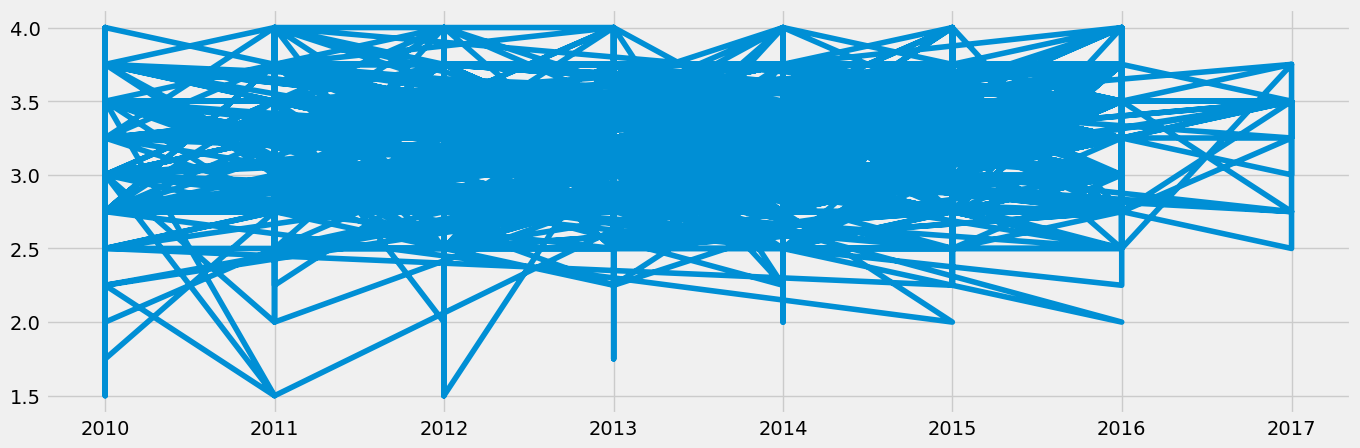

In [66]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

The plot is still cluttered because there may be multiple reviews or data points for each year, which results in overlapping lines.
 So aggregated the data, such as taking the mean of the ratings per year .

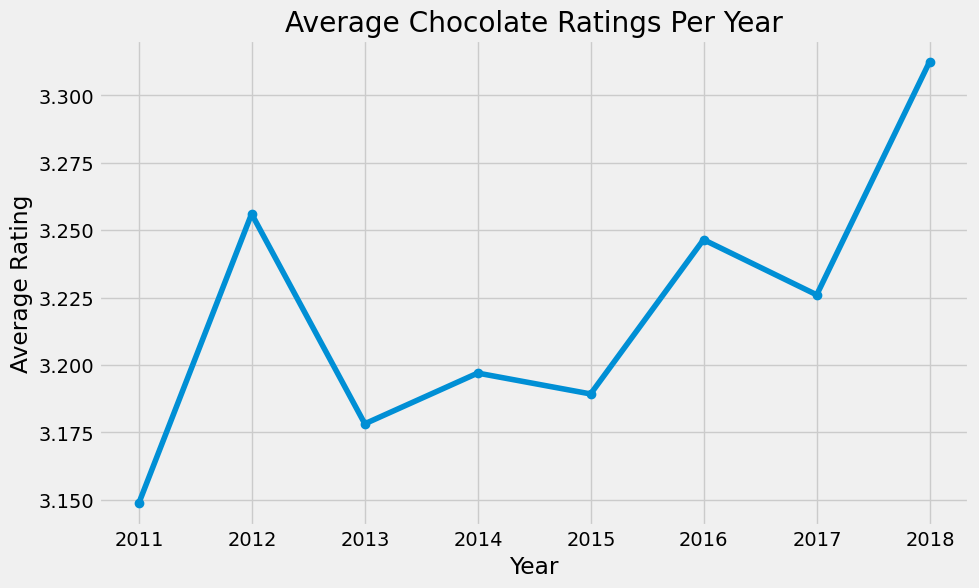

In [68]:
# Resample the data to get the mean Rating per year
df_sub_yearly = df_sub['Rating'].resample('Y').mean()

# Plot the aggregated data
plt.figure(figsize=(10, 6))
plt.plot(df_sub_yearly.index, df_sub_yearly, marker='o')
plt.title('Average Chocolate Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

Trend Over Time: The graph shows a generally increasing trend in average ratings over the years. This suggests that chocolate quality, as perceived by reviewers, has improved in recent years.

Conclusion
The data indicates a positive shift in chocolate ratings over time, reflecting either improvements in chocolate quality or evolving consumer preferences. This analysis provides valuable insights for chocolate manufacturers and marketers aiming to enhance their products in line with consumer expectations.

In [70]:
# Check for missing values (you shouldn't have any)

df_sub.isnull().sum() 

Rating    0
dtype: int64

In [71]:
# Check for duplicates

dups = df_sub.duplicated()
dups.sum()

1419

Ignore the dups as i have set January as a month in resampling and may be in a year same months are reflecting.

### 3. Time-series analysis: decomposition

<Figure size 1200x800 with 0 Axes>

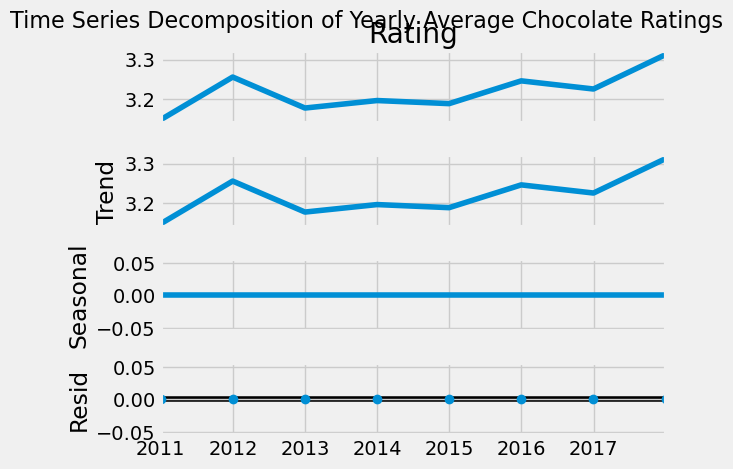

In [74]:
# Decompose the resampled data using an additive model
decomposition_yearly = sm.tsa.seasonal_decompose(df_sub_yearly, model='additive', period=1)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
decomposition_yearly.plot()
plt.suptitle('Time Series Decomposition of Yearly Average Chocolate Ratings', fontsize=16)
plt.show()

Interpretation:

Trend: The trend shows a relatively consistent increase in the average ratings over time, with a slight dip around 2013-2014 before picking up again.

Seasonal: The seasonal component appears flat, suggesting no strong seasonal variation in the ratings on a yearly basis. This is expected when working with yearly data.

Residual: The residuals are quite small, indicating that the model explains most of the variability in the data. These values show the noise or error left after accounting for trend and seasonality.

### 4. Testing for stationarity

In [77]:
#To assess whether the time series is stationary, we'll conduct a Dickey-Fuller test
 #If the p-value is low (below a significance threshold like 0.05), we can reject the null hypothesis and conclude that the series is stationary.
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result_yearly = adfuller(df_sub_yearly.dropna())
print('ADF Statistic:', result_yearly[0])
print('p-value:', result_yearly[1])

# Critical values
for key, value in result_yearly[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -2.1932707004290948
p-value: 0.20869686391838954
Critical Value (1%): -4.9386902332361515
Critical Value (5%): -3.477582857142857
Critical Value (10%): -2.8438679591836733


Interpretation
The p-value (0.209) is greater than 0.05, which means we fail to reject the null hypothesis.

The null hypothesis (H₀) in the ADF test states that the time series is non-stationary.

Since we fail to reject the null hypothesis, it indicates that the data is non-stationary.

### Apply Differencing

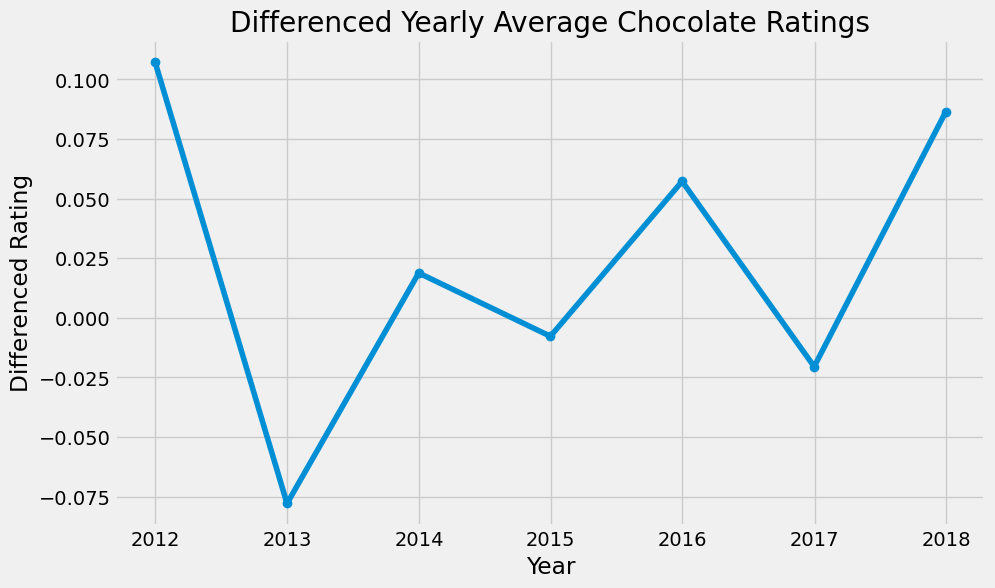

ADF Statistic after differencing: -5.570083857227001
p-value after differencing: 1.4742349081463766e-06


In [80]:
#: Since the data is non-stationary, we should apply differencing to remove the trend and check if the series becomes stationary after differencing.
# First differencing
df_sub_yearly_diff = df_sub_yearly.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(df_sub_yearly_diff.index, df_sub_yearly_diff, marker='o')
plt.title('Differenced Yearly Average Chocolate Ratings')
plt.xlabel('Year')
plt.ylabel('Differenced Rating')
plt.grid(True)
plt.show()

# Perform Dickey-Fuller test on differenced data
result_diff_yearly = adfuller(df_sub_yearly_diff)
print('ADF Statistic after differencing:', result_diff_yearly[0])
print('p-value after differencing:', result_diff_yearly[1])

Interpretation:
The p-value is much lower than 0.05, indicating that we can reject the null hypothesis.

The series is now stationary after the first-order differencing.

### 5.Check for autocorrelations

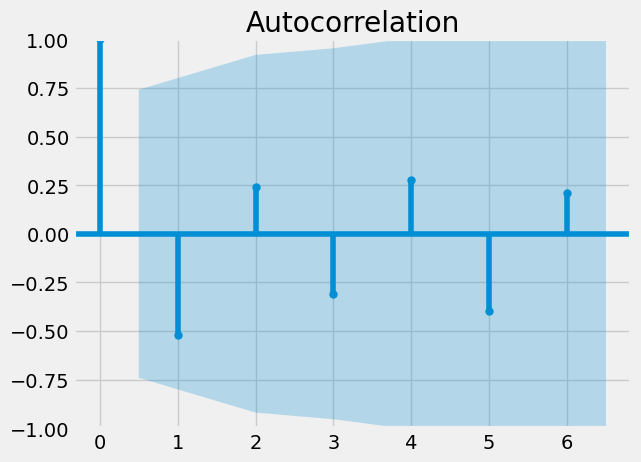

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_sub_yearly_diff)
plt.show()

Interpretation:
The strong spike at Lag 1 indicates that there's a significant relationship between consecutive differenced values.

Subsequent lags show smaller spikes, but they are within the confidence interval (shaded blue area), suggesting that after the first couple of lags, there is less correlation, and the series becomes more random.

# Export Data

In [102]:
df.to_pickle(r'D:\Sonal\career foundry\CareerFoundry\Data Immersion\Achievement 6\Exc 6.6\New folder\df_time_series.pkl')